Import libraries

In [ ]:
import os 
import math
import numpy as np 
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import torch

from utils import load_pickle, load_json, pickle_data, compute_MS_sim

Settings

In [2]:
data_folder = "/data/rbg/users/klingmin/projects/MS_processing/data/"
splits_folder = "/data/rbg/users/klingmin/projects/MS_processing/data_splits"

cache_folder = "./cache/baselines"
if not os.path.exists(cache_folder): os.makedirs(cache_folder)

datasets = ["canopus", "massspecgym", "nist2023"]
splits = ["random", "inchikey_vanilla", "scaffold_vanilla", "LS"]

Helper Functions

In [4]:
def plot_spectrum(spec, xlim, annotate_top_k=None, output_path = None):

    mz_values = [p["mz"] for p in spec]
    intensity_values = [p["intensity"] for p in spec]
    intensity_values = [i / max(intensity_values) for i in intensity_values]

    plt.figure(figsize=(9, 6))
    plt.vlines(mz_values, 0, intensity_values, color="#4895EF", linewidth=2)
    plt.xlabel("m/z", fontsize = 17)
    plt.ylabel("Intensity", fontsize = 17)

    # Set tick intervals (grid spacing)
    plt.xticks(np.arange(0, xlim, 25))   # x-axis: ticks every 1 unit
    plt.yticks(np.arange(0, 1.2, 0.1))  # y-axis: ticks every 0.5 unit

    plt.grid(True, alpha = 0.3)

    plt.xlim(0, xlim)
    plt.ylim(bottom=0)

    if xlim:
        plt.xlim(0, xlim)

    # Annotate top-k peaks by intensity
    if annotate_top_k is not None:
        topk_idx = sorted(range(len(intensity_values)), key=lambda i: intensity_values[i], reverse=True)[:annotate_top_k]
        for i in topk_idx:
            mz = mz_values[i]
            intensity = intensity_values[i]
            if round(mz,2) == 338.28: continue
            plt.text(
                mz, intensity + 0.02, f"{mz:.2f}",
                ha='center', va='bottom', fontsize=15
            )

    plt.tight_layout()
    if output_path is not None: 
        plt.savefig(output_path)
    plt.show()

Load in the data

In [5]:
dataset_info = {} 

canopus = load_pickle(os.path.join(data_folder, "canopus", "canopus_w_mol_info_w_frag_CF_preds.pkl"))
canopus = {str(r["id_"]) : r for r in canopus}
print("Done loading canopus")

massspecgym = load_pickle(os.path.join(data_folder, "massspecgym", "massspecgym_w_mol_info_w_frag_CF_preds.pkl"))
massspecgym = {str(r["id_"]) : r for r in massspecgym}
print("Done loading MSG")

# nist2023 = load_pickle(os.path.join(data_folder, "nist2023", "nist2023_w_mol_info_w_frag_CF_preds.pkl"))
# nist2023 = {r["id_"] : r for r in nist2023}
# print("Done loading NIST2023")

dataset_info["canopus"] = canopus
dataset_info["massspecgym"] = massspecgym
# dataset_info["nist2023"] = nist2023

Done loading canopus
Done loading MSG


Get repeated spectra info

In [6]:
repeated_spectra_info = {} 

canopus_repeated = {} 

for k, v in canopus.items(): 

    inchikey = v["inchikey_original"][:14]
    if inchikey not in canopus_repeated: canopus_repeated[inchikey] = [] 
    canopus_repeated[inchikey].append(k)

massspecgym_repeated = {} 

for k, v in massspecgym.items(): 

    inchikey = v["inchikey_original"][:14]
    if inchikey not in massspecgym_repeated: massspecgym_repeated[inchikey] = [] 
    massspecgym_repeated[inchikey].append(k)

# # nist2023_repeated = {} 

# for k, v in nist2023.items(): 

#     inchikey = v["inchikey_original"][:14]
#     if inchikey not in nist2023_repeated: nist2023_repeated[inchikey] = [] 
#     nist2023_repeated[inchikey].append(k)

repeated_spectra_info["canopus"] = canopus_repeated
repeated_spectra_info["massspecgym"] = massspecgym_repeated
# repeated_spectra_info["nist2023"] = nist2023_repeated

Get pairwise similarity for train spectra with repeats

In [7]:
for dataset, rec in repeated_spectra_info.items():
        
        pairwise_sim = []
        for inchikey, spec in rec.items():
                
                if len(spec) == 1: continue
                
                for i in range(len(spec)):
                        for j in range(i+1, len(spec)):
                                sim = compute_MS_sim(dataset_info[dataset][spec[i]], dataset_info[dataset][spec[j]])
                                pairwise_sim.append((sim, spec[i], spec[j]))
        
        pairwise_sim = sorted(pairwise_sim, key = lambda x: x[0])
        print(dataset, pairwise_sim[:10])

canopus [(0.0, '65', '75'), (0.0, '65', '76'), (0.0, '68', '75'), (0.0, '69', '75'), (0.0, '69', '76'), (0.0, '70', '75'), (0.0, '70', '76'), (0.0, '71', '75'), (0.0, '71', '76'), (0.0, '72', '75')]


KeyboardInterrupt: 

In [ ]:
# for i in range(len(pairwise_sim)):

#     id_1, id_2 = pairwise_sim[i][1], pairwise_sim[i][2]
    
#     spec1 = dataset_info[dataset][id_1]["peaks"]
#     spec2 = dataset_info[dataset][id_2]["peaks"]

#     mol1 = dataset_info[dataset][id_1]["smiles"]
#     mol2 = dataset_info[dataset][id_2]["smiles"]

#     cond1 = dataset_info[dataset][id_1]["precursor_type"], dataset_info[dataset][id_1]["instrument_type"], dataset_info[dataset][id_1]["collision_energy"]
#     cond2 = dataset_info[dataset][id_2]["precursor_type"], dataset_info[dataset][id_2]["instrument_type"], dataset_info[dataset][id_2]["collision_energy"]

#     if "Unknown" in cond1[1]: continue 
#     if cond1[-1] == "-" or cond2[-1] == "-": continue
#     if cond1[0] == cond2[0]: continue
#     if cond1[-1] != cond2[-1]: continue

#     # spec3 = dataset_info[dataset][pairwise_sim[i+1][2]]["peaks"]
#     print(cond1, cond2)
#     print(i, pairwise_sim[i], pairwise_sim[i+1], pairwise_sim[i+2])
#     print(mol1, mol2)
    
#     print("*" * 80)

#     spec1_output_path = os.path.join(cache_folder, f"{id_1}_spec_MSG.jpg")
#     spec2_output_path = os.path.join(cache_folder, f"{id_2}_spec_MSG.jpg")

#     plot_spectrum(spec1, xlim = 720, annotate_top_k=6, output_path = spec1_output_path)
#     plot_spectrum(spec2, xlim = 720, annotate_top_k=5, output_path = spec2_output_path)

#     mol =Chem.MolFromSmiles(mol1)
#     mol
#     img = Draw.MolToImage(mol)
#     img.save(os.path.join(cache_folder, "mol.jpg"))

#     print("*" * 80)
#     print()

#     break

In [ ]:
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity

A = np.random.standard_normal(100 * 4096).reshape(100, 4096)
B = np.random.standard_normal(128 * 4096).reshape(128, 4096)

similarity = cosine_similarity(A, B)

In [ ]:
idx = np.argsort(similarity, axis=1)[:, -20:][:, ::-1]
idx

In [ ]:
# similarity[np.argsort(similarity, axis = 0)[:, -20:][::-1]]

In [ ]:
np.take_along_axis(similarity, idx, axis=1).shape

Get reasons if we just choose to predict the sum of the top k 

In [ ]:
k = 1

for dataset in datasets:

    all_jaccard = [] 

    for split in splits:

        similarity_path = os.path.join(cache_folder, f"{dataset}_{split}.pkl")
        similarity, test_ids, train_ids = load_pickle(similarity_path)

        train_MS = [bin_MS(dataset_info[dataset][id_]["peaks"]) for id_ in train] 
        test_MS = [bin_MS(dataset_info[dataset][id_]["peaks"]) for id_ in test] 
                

        for i, test in enumerate(test_ids): 

            test_FP = string_to_bits(dataset_info[dataset][test]["FPs"]["morgan4_4096"])
            test_FP = np.expand_dims(test_FP, axis = 0)
            top_k_train = np.argsort(similarity[i, :])[-k:][::-1]

            top_k_FP = np.array([string_to_bits(dataset_info[dataset][train_ids[j]]["FPs"]["morgan4_4096"]) for j in top_k_train])
            FP_pred = top_k_FP.sum(axis = 0)
            FP_pred = np.expand_dims(FP_pred, axis = 0)

            jaccard = batch_jaccard_index(FP_pred, test_FP)
            all_jaccard.append(jaccard)

        print(dataset, split, np.mean(all_jaccard))

In [ ]:
k = 1

for dataset in datasets:
    if dataset != "canopus": continue

    all_jaccard = [] 

    for split in splits:

        similarity_path = os.path.join(cache_folder, f"{dataset}_{split}_binary.pkl")
        similarity, test_ids, train_ids = load_pickle(similarity_path)

        for i, test in enumerate(test_ids): 

            test_FP = string_to_bits(dataset_info[dataset][test]["FPs"]["morgan4_4096"])
            test_FP = np.expand_dims(test_FP, axis = 0)
            top_k_train = np.argsort(similarity[i, :])[-k:][::-1]

            top_k_FP = np.array([string_to_bits(dataset_info[dataset][train_ids[j]]["FPs"]["morgan4_4096"]) for j in top_k_train])
            FP_pred = top_k_FP.sum(axis = 0)
            FP_pred = np.expand_dims(FP_pred, axis = 0)

            jaccard = batch_jaccard_index(FP_pred, test_FP)
            all_jaccard.append(jaccard)

        print(dataset, split, np.mean(all_jaccard))

In [ ]:
k = 1

for dataset in datasets:

    all_jaccard = [] 

    for split in splits:

        similarity_path = os.path.join(cache_folder, f"{dataset}_{split}.pkl")
        similarity, test_ids, train_ids = load_pickle(similarity_path)

        for i, test in enumerate(test_ids): 

            test_FP = string_to_bits(dataset_info[dataset][test]["FPs"]["morgan4_4096"])
            test_FP = np.expand_dims(test_FP, axis = 0)
            top_k_train = np.argsort(similarity[i, :])[-k:][::-1]

            top_k_FP = np.array([string_to_bits(dataset_info[dataset][train_ids[j]]["FPs"]["morgan4_4096"]) for j in top_k_train])
            FP_pred = top_k_FP.sum(axis = 0)
            FP_pred = np.expand_dims(FP_pred, axis = 0)

            jaccard = batch_jaccard_index(FP_pred, test_FP)
            all_jaccard.append(jaccard)

        print(dataset, split, np.mean(all_jaccard))

Additional analysis to figure out issues

In [22]:
combi = {} 

for k, v in canopus.items():

    peaks = set([f["comment"]["f_pred"] for f in v["peaks"]])
    peaks.discard('')
    peaks = ",".join(sorted(peaks))
    
    if peaks not in combi: 
        combi[peaks] = []

    combi[peaks].append((k, v["smiles"]))


In [23]:
for peak, ids in combi.items():

    if len(ids) == 1: continue 

    print(peaks.split(","))
    print(ids)
    a = z 


['C10H10', 'C10H10Cl', 'C10H10O2', 'C10H15ClO2', 'C10H18O', 'C10H5O', 'C10H5O2', 'C10H7O2', 'C10H7O3', 'C10H9', 'C11H10O', 'C11H11O2', 'C11H18O', 'C11H7O2', 'C11H7O3', 'C11H9O', 'C11H9O2', 'C11H9O3', 'C12H', 'C12H11Cl', 'C12H11O', 'C12H18ClO2', 'C12H7O2', 'C12H8', 'C12H9O2', 'C12H9O3', 'C13H10O3', 'C13H12O2', 'C13H7O', 'C13H9O', 'C13H9O2', 'C14H10', 'C14H10O', 'C14H11O', 'C14H11O3', 'C15H11', 'C15H12', 'C15H13Cl', 'C15H13O', 'C15H14O3', 'C15H9ClO', 'C16H11O', 'C16H12Cl', 'C16H13O3', 'C16H15O3', 'C16H17Cl', 'C16H19ClO2', 'C16H19ClO3', 'C16H20ClO2', 'C16H5Cl', 'C17H11', 'C17H20', 'C17H20O', 'C19H10O', 'C19H12ClO2', 'C19H12O2', 'C20H12', 'C21H13', 'C21H13ClO', 'C21H15', 'C21H20ClO2', 'C21H5', 'C22H15O', 'C22H16ClO2', 'C22H18ClO3', 'C3Cl', 'C7H10Cl', 'C7H3O3', 'C7H6Cl', 'C7H9O2', 'C8H14ClO3', 'C9H6Cl', 'C9H6O3', 'C9H7O', 'C9H8']
[('60', 'COC1=CC2=C(C(=C1)OC)C(=C(C(=O)O2)C3=CC4=C(C=C3)OCO4)OC'), ('61', 'COC1=CC2=C(C(=C1)OC)C(=C(C(=O)O2)C3=CC4=C(C=C3)OCO4)OC'), ('75', 'CC(C(C12CC1CC=CC2=O)O)

NameError: name 'z' is not defined

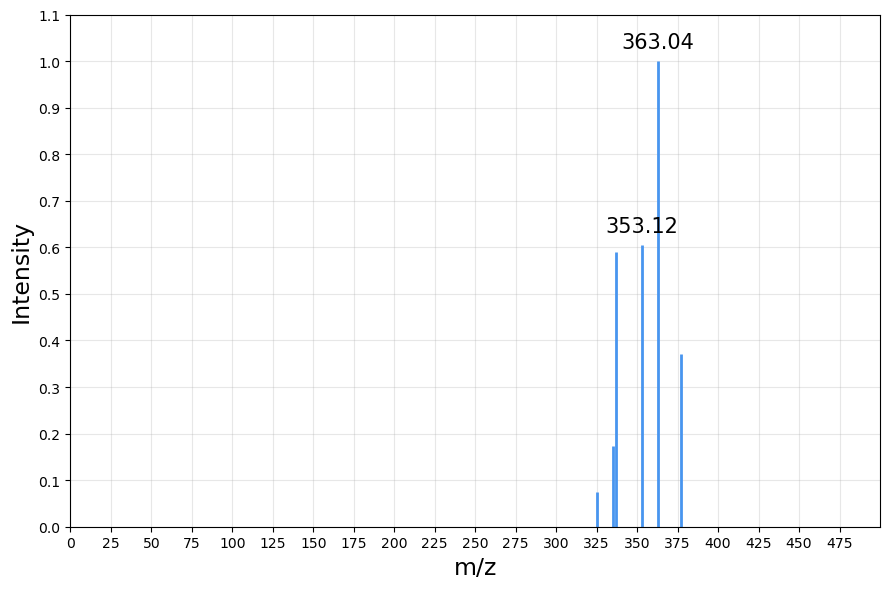

In [32]:
plot_spectrum(canopus["60"]["peaks"], xlim = 500, annotate_top_k= 2)

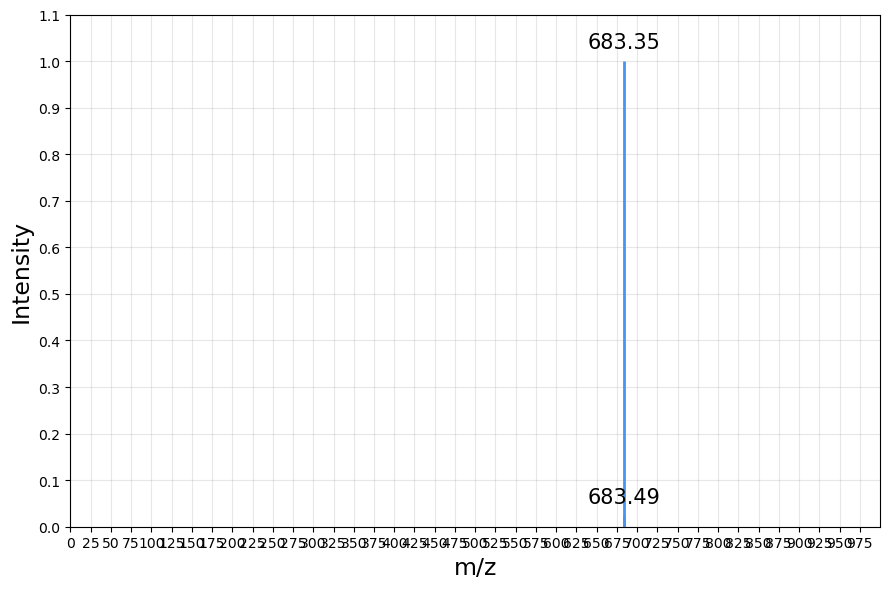

In [36]:
plot_spectrum(canopus["326"]["peaks"], xlim = 1000, annotate_top_k= 2)